In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests
import pandas as pd
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import EMAIndicator, MACD, ADXIndicator
from ta.volatility import BollingerBands
from sklearn.model_selection import train_test_split
from ta.volume import OnBalanceVolumeIndicator
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix
import simfin as sf

In [3]:
import sys
import os

load_dotenv()
# module_path = os.path.abspath(os.path.join('..'))
module_path = os.path.join(os.path.abspath(os.path.join('..')), 'app')
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

import FinanceLib as fl

C:\Projects\FinanceProject\app


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [17]:
def fetch_and_process_data(stock_symbol, source_type, start_date, end_date):
    # Fetch historical stock price data
    if source_type == 'yf_api':
        stock_data = yf.download(stock_symbol, start=start_date, end=end_date)
        stock_data["symbol"] = stock_symbol
    elif source_type == 'db' :
        stock_data = fl.get_stock_quote_from_db(stock_symbol, "america", start_date, end_date, is_dt_index=1, is_stock_index=0)
        stock_data = stock_data.rename_axis('Date')
        stock_data = stock_data.rename(columns={'stock': 'symbol', 
                                        'openvalue': 'Open', 
                                        'highvalue': 'High', 
                                        'lowvalue': 'Low', 
                                        'closevalue': 'Close', 
                                        'adjclose': 'Adj Close', 
                                        'volume': 'Volume'})
    
    # Check for missing values
    stock_data.fillna(method='ffill', inplace=True)    
    # Create the Target column
    stock_data['Target'] = (stock_data['Close'].shift(-1) > stock_data['Close']).astype(int)
    stock_data.dropna(inplace=True)
    
    # Feature Engineering
    stock_data['MA_50'] = stock_data['Close'].rolling(window=50).mean()
    stock_data['MA_200'] = stock_data['Close'].rolling(window=200).mean()
    stock_data['EMA_50'] = EMAIndicator(stock_data['Close'], window=50).ema_indicator()
    stock_data['EMA_200'] = EMAIndicator(stock_data['Close'], window=200).ema_indicator()
    stock_data['Volatility'] = stock_data['Close'].rolling(window=50).std()
    stock_data['Daily_Return'] = stock_data['Close'].pct_change()
    stock_data['RSI'] = RSIIndicator(stock_data['Close']).rsi()
    stock_data['Stochastic'] = StochasticOscillator(stock_data['High'], stock_data['Low'], stock_data['Close']).stoch()
    stock_data['ADX'] = ADXIndicator(stock_data['High'], stock_data['Low'], stock_data['Close']).adx()
    stock_data['OBV'] = OnBalanceVolumeIndicator(stock_data['Close'], stock_data['Volume']).on_balance_volume()
    macd = MACD(stock_data['Close'])
    stock_data['MACD'] = macd.macd()
    stock_data['MACD_Signal'] = macd.macd_signal()
    stock_data['MACD_Diff'] = macd.macd_diff()
    bb = BollingerBands(stock_data['Close'])
    stock_data['BB_High'] = bb.bollinger_hband()
    stock_data['BB_Low'] = bb.bollinger_lband()
    
    # Drop rows with NaN values generated by these calculations
    stock_data.dropna(inplace=True)
    
    # Fetch and merge fundamental data
#     fundamental_data = fetch_time_series_fundamental_data(stock_symbol)
#     fundamental_data = fetch_alpha_vantage_data(stock_symbol, alpha_vantage_api_key)
#     stock_data = stock_data.merge(fundamental_data, left_index=True, right_index=True, how='left')
    
    # Fill any remaining NaN values in fundamental data
    stock_data.fillna(method='ffill', inplace=True)
    
    return stock_data

In [18]:
def get_stock_data(stock_symbols, source_type, start_date, end_date):
    stocks = {}
    stocks_list = []

    for symbol in stock_symbols:
        stock_data = fetch_and_process_data(symbol, source_type, start_date, end_date)
        stocks[symbol] = stock_data
        stocks_list.append(stock_data.iloc[:-1])

    final_stock_df = pd.concat(stocks_list, ignore_index=False)
    return stocks, final_stock_df    

In [41]:
def fit_stock_predict_model(stock_df, features, target_name='Target', scoring='precision'):    
    stock_models = {}
    n_splits = 5

    final_stock_df = stock_df
    X = final_stock_df[features]
    y = final_stock_df[target_name]

    tscv = TimeSeriesSplit(n_splits=5)

    # XGBoost Classifier
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

    # Hyperparameter tuning
    param_distributions = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 4, 5, 6],
        'colsample_bytree': [0.3, 0.7],
        'subsample': [0.7, 0.9],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }

    random_search = RandomizedSearchCV(model, param_distributions, n_iter=20, scoring=scoring, cv=tscv, verbose=1, n_jobs=-1)

    # Fit model using TimeSeriesSplit
    random_search.fit(X, y)

    # Evaluate model
    y_pred = random_search.predict(X)
    rprt = classification_report(y, y_pred)
#     print(classification_report(y, y_pred))
    return random_search.best_estimator_, rprt

In [42]:
def get_probability_for_stock(stock_symbols, stocks, model):
    predictions = {}
    for symbol in stock_symbols:
        stock_data = stocks[symbol]
        latest_data = stock_data.iloc[-1][features].values.reshape(1, -1)
        probability = model.predict_proba(latest_data)[0][1]
        predictions[symbol] = probability
        print(f'Predicted probability of stock price for date {stock_data.iloc[-1].name} increase for {symbol}: {probability}')
    return predictions

In [47]:
stock_symbols = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']  
features = ['MA_50', 'MA_200', 'EMA_50', 'EMA_200', 'Volatility', 'Daily_Return', 'RSI', 'Stochastic', 'ADX', 'OBV', 'MACD', 'MACD_Signal', 'MACD_Diff', 'BB_High', 'BB_Low']
start_date = '2018-01-01'
end_date = '2024-08-01'

#get dataframe
stocks, stock_df = get_stock_data(stock_symbols, "db", start_date, end_date)

#fit model
random_search_xgboost_model, classification_report = fit_stock_predict_model(stock_df, features)
print(classification_report)

#get predictions
predictions = get_probability_for_stock(stock_symbols, stocks, random_search_xgboost_model)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.80      0.63      0.70      3418
           1       0.72      0.86      0.79      3862

    accuracy                           0.75      7280
   macro avg       0.76      0.75      0.75      7280
weighted avg       0.76      0.75      0.75      7280

Predicted probability of stock price for date 2024-08-01 00:00:00 increase for AAPL: 0.34856483340263367
Predicted probability of stock price for date 2024-08-01 00:00:00 increase for GOOGL: 0.6290106177330017
Predicted probability of stock price for date 2024-08-01 00:00:00 increase for MSFT: 0.47596949338912964
Predicted probability of stock price for date 2024-08-01 00:00:00 increase for AMZN: 0.4063778817653656
Predicted probability of stock price for date 2024-08-01 00:00:00 increase for TSLA: 0.49289387464523315


In [48]:
predictions

{'AAPL': 0.34856483,
 'GOOGL': 0.6290106,
 'MSFT': 0.4759695,
 'AMZN': 0.40637788,
 'TSLA': 0.49289387}

In [49]:
print(classification_report)

              precision    recall  f1-score   support

           0       0.80      0.63      0.70      3418
           1       0.72      0.86      0.79      3862

    accuracy                           0.75      7280
   macro avg       0.76      0.75      0.75      7280
weighted avg       0.76      0.75      0.75      7280



In [50]:
stock_models = {}
n_splits = 5

final_stock_df = stock_df
X = final_stock_df[features]
y = final_stock_df[target_name]

tscv = TimeSeriesSplit(n_splits=5)

# XGBoost Classifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Hyperparameter tuning
param_distributions = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'colsample_bytree': [0.3, 0.7],
    'subsample': [0.7, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

random_search = RandomizedSearchCV(model, param_distributions, n_iter=20, scoring=scoring, cv=tscv, verbose=1, n_jobs=-1)

# Fit model using TimeSeriesSplit
random_search.fit(X, y)

# Evaluate model
y_pred = random_search.predict(X)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [51]:
accuracy_score(y_true=y, y_pred=y_pred)

0.7506868131868132

### Проверка результата на тестовой выборке (берем другие тикеры)

In [52]:
stock_symbols_test = ['FCX', 'ADBE', 'AMD']
stocks_test, stock_df_test = get_stock_data(stock_symbols_test, "db", start_date, end_date)

final_stock_df_test = stock_df_test
X_test = final_stock_df_test[features]
y_test = final_stock_df_test[target_name]

In [53]:
y_pred_test = random_search.predict(X_test)

In [55]:
accuracy_score(y_true=y_test, y_pred=y_pred_test)

0.5089285714285714

In [60]:
def plot_confusion_matrix(y_true, y_pred):
    """
    Plot a classification confusion matrix.
    
    :param y_true: Array of true classes.
    :param y_pred: Array of predicted classes.
    """
    
    # Class labels.
    labels = [1.0, -1.0]
    labels_text = ['Gain', 'Loss']

    # Create confusion matrix.
    mat = confusion_matrix(y_true=y_true, y_pred=y_pred,
                           labels=labels)
    
    # Normalize so all matrix entries sum to 1.0
    mat = mat / len(y_true)
    
    # Plot the matrix as a heatmap.
    sns.heatmap(mat, robust=True,
                xticklabels=labels_text,
                yticklabels=labels_text)

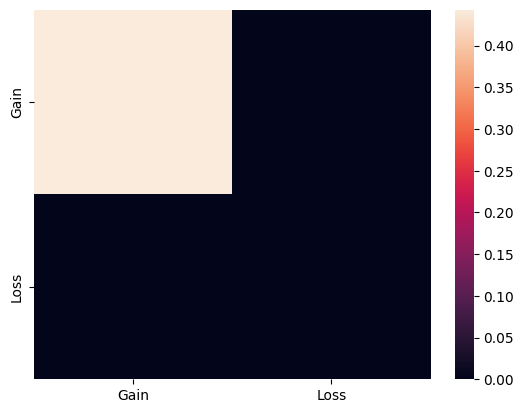

In [61]:
plot_confusion_matrix(y_true=y, y_pred=y_pred)

### Simfin datahub for fundamental data

In [68]:
simfin_api_key = os.getenv("SIMFIN_API_KEY")
# Set your API-key for downloading data. This key gets the free data.
sf.set_api_key(simfin_api_key)
# Set the local directory where data-files are stored.
# The directory will be created if it does not already exist.
sf.set_data_dir('~/simfin_data/')

In [69]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=30)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 7

In [70]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: total: 0 ns
Wall time: 0 ns


In [117]:
REPORT_DATE, PUBLISH_DATE, RESTATED_DATE = 'Report Date', 'Publish Date', 'Restated Date'

In [71]:
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-balance-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Dataset "us-shareprices-daily" not on disk.
- Downloading ... 100.0%
- Extracting zip-file ... Done!
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!


In [121]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

CPU times: total: 0 ns
Wall time: 0 ns


In [76]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
CPU times: total: 4.62 s
Wall time: 15.2 s


In [92]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: total: 46.9 ms
Wall time: 5.81 s


In [93]:
df_signals.head()

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2018-09-04                                NaN             NaN   
       2018-09-05                                NaN             NaN   
       2018-09-06                                NaN             NaN   
       2018-09-07                                NaN             NaN   
       2018-09-10                                NaN             NaN   

                   CapEx / (Depr + Amor)  Current Ratio  Debt Ratio  \
Ticker Date                                                           
A      2018-09-04                    NaN            NaN         NaN   
       2018-09-05                    NaN            NaN         NaN   
       2018-09-06                    NaN            NaN         NaN   
       2018-09-07                    NaN            NaN         NaN   
       2018-09-10                    NaN            NaN         NaN   

                   Dividends / FCF  Gross Profit Margin  Interest Coverage  \
Ticker Date                                                                  
A      2018-09-04              NaN                  NaN                NaN   
       2018-09-05              NaN                  NaN                NaN   
       2018-09-06              NaN                  NaN                NaN   
       2018-09-07              NaN                  NaN                NaN   
       2018-09-10              NaN                  NaN                NaN   

                   Inventory Turnover  Log Revenue  ...  Earnings Yield  \
Ticker Date                                         ...                   
A      2018-09-04                 NaN          NaN  ...             NaN   
       2018-09-05                 NaN          NaN  ...             NaN   
       2018-09-06                 NaN          NaN  ...             NaN   
       2018-09-07                 NaN          NaN  ...             NaN   
       2018-09-10                 NaN          NaN  ...             NaN   

                   FCF Yield  Market-Cap  P/Cash  P/E  P/FCF  P/NCAV  \
Ticker Date                                                            
A      2018-09-04        NaN         NaN     NaN  NaN    NaN     NaN   
       2018-09-05        NaN         NaN     NaN  NaN    NaN     NaN   
       2018-09-06        NaN         NaN     NaN  NaN    NaN     NaN   
       2018-09-07        NaN         NaN     NaN  NaN    NaN     NaN   
       2018-09-10        NaN         NaN     NaN  NaN    NaN     NaN   

                   P/NetNet  P/Sales  Price to Book Value  
Ticker Date                                                
A      2018-09-04       NaN      NaN                  NaN  
       2018-09-05       NaN      NaN                  NaN  
       2018-09-06       NaN      NaN                  NaN  
       2018-09-07       NaN      NaN                  NaN  
       2018-09-10       NaN      NaN                  NaN  

[5 rows x 42 columns]

In [94]:
df_signals.shape

(5359473, 42)

In [102]:
df_signals.columns

Index(['(Dividends + Share Buyback) / FCF', 'Asset Turnover',
       'CapEx / (Depr + Amor)', 'Current Ratio', 'Debt Ratio',
       'Dividends / FCF', 'Gross Profit Margin', 'Interest Coverage',
       'Inventory Turnover', 'Log Revenue', 'Net Acquisitions / Total Assets',
       'Net Profit Margin', 'Quick Ratio', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Assets', 'Return on Equity',
       'Return on Research Capital', 'Share Buyback / FCF', 'Assets Growth',
       'Assets Growth QOQ', 'Assets Growth YOY', 'Earnings Growth',
       'Earnings Growth QOQ', 'Earnings Growth YOY', 'FCF Growth',
       'FCF Growth QOQ', 'FCF Growth YOY', 'Sales Growth', 'Sales Growth QOQ',
       'Sales Growth YOY', 'Dividend Yield', 'Earnings Yield', 'FCF Yield',
       'Market-Cap', 'P/Cash', 'P/E', 'P/FCF', 'P/NCAV', 'P/NetNet', 'P/Sales',
       'Price to Book Value'],
      dtype='object')

In [103]:
df.index

RangeIndex(start=0, stop=4716, step=1)

In [95]:
stock_symbols = ['AAPL', 'MSFT', 'AMZN', 'TSLA']

In [96]:
df_signals_to_calc = df_signals.loc[stock_symbols]

In [97]:
df_signals_to_calc.shape

(4960, 42)

In [99]:
# Remove all rows with only NaN values.
df_signals_to_calc = df_signals_to_calc.dropna(how='all').reset_index(drop=False)

In [100]:
df_signals_to_calc.head()

,Ticker,Date,(Dividends + Share Buyback) / FCF,Asset Turnover,CapEx / (Depr + Amor),Current Ratio,Debt Ratio,Dividends / FCF,Gross Profit Margin,Interest Coverage,...,Earnings Yield,FCF Yield,Market-Cap,P/Cash,P/E,P/FCF,P/NCAV,P/NetNet,P/Sales,Price to Book Value
0,AAPL,2018-11-29,1.337799,0.726215,1.22104,1.124524,0.313534,0.213846,0.383437,-28.9599,...,0.066306,0.071419,8.978196e+11,13.541569,15.081547,14.001958,-7.056167,-5.846308,3.380408,8.379325
1,AAPL,2018-11-30,1.337799,0.726215,1.22104,1.124524,0.313534,0.213846,0.383437,-28.9599,...,0.066663,0.071802,8.930195e+11,13.469170,15.000915,13.927098,-7.018441,-5.815051,3.362335,8.334526
2,AAPL,2018-12-03,1.337799,0.726215,1.22104,1.124524,0.313534,0.213846,0.383437,-28.9599,...,0.064426,0.069394,9.240201e+11,13.936745,15.521663,14.410570,-7.262083,-6.016917,3.479057,8.623855
3,AAPL,2018-12-04,1.337799,0.726215,1.22104,1.124524,0.313534,0.213846,0.383437,-28.9599,...,0.067387,0.072583,8.834193e+11,13.324373,14.839651,13.777378,-6.942991,-5.752537,3.326189,8.244928
4,AAPL,2018-12-06,1.337799,0.726215,1.22104,1.124524,0.313534,0.213846,0.383437,-28.9599,...,0.068143,0.073397,8.736190e+11,13.176559,14.675027,13.624539,-6.865969,-5.688722,3.289290,8.153462


In [101]:
df_signals_to_calc['Date'].min(), df_signals_to_calc['Date'].max()

(Timestamp('2018-11-29 00:00:00'), Timestamp('2023-08-08 00:00:00'))

In [108]:
tickers = df_signals.groupby(level='Ticker').agg({'Current Ratio': 'count'})
tickers = tickers.rename(columns={'Current Ratio': 'CountRows'})

In [109]:
tickers.shape

(5213, 1)

In [110]:
tickers.head()

,CountRows
Ticker,
A,1159
AA,1179
AAC,362
AACI,0
AAGH,237


In [115]:
tickers[tickers.index == 'AAPL']

,CountRows
Ticker,
AAPL,1179


In [130]:
from Utils import merge_df_to_pg, get_conn_pg_engine
import SimfinLib as sfl

In [131]:
# Create SQLAlchemy engine
engine = get_conn_pg_engine(False)
table_name = 'simfin_stats'
schema_name = 'finance'
merge_key_list = ['report_date', 'ticker']

In [137]:
for ticker in tickers.index:
    print(ticker)
    if '_delisted' not in ticker:        
        df_ticker = df_signals.xs(ticker, level='Ticker')
        df_ticker['ticker'] = ticker
        df_ticker = sfl.simfin_rename_columns('stats', df_ticker)
        df_ticker = df_ticker.reset_index("report_date")
        merge_df_to_pg(df_ticker, engine, table_name, schema_name, merge_key_list)

A
AA
AAC
AACI
AAGH
AAIC
AAL


KeyboardInterrupt: 

In [136]:
ticker = 'AAPL'
df_ticker = df_signals.xs(ticker, level='Ticker')
df_ticker['ticker'] = ticker
df_ticker = sfl.simfin_rename_columns('stats', df_ticker)
df_ticker = df_ticker.reset_index("report_date")
merge_df_to_pg(df_ticker, engine, table_name, schema_name, merge_key_list)

In [133]:
df_ticker.head(10)

,report_date,dividends_and_share_buyback_divide_fcf,asset_turnover,capex_divide_depr_amor,current_ratio,debt_ratio,dividends_divide_fcf,gross_profit_margin,interest_coverage,inventory_turnover,...,fcf_yield,market_cap,p_divide_cash,p_divide_e,p_divide_fcf,p_divide_ncav,p_divide_netnet,p_divide_sales,price_to_book_value,Ticker
0,2018-09-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
1,2018-09-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
2,2018-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
3,2018-09-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
4,2018-09-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
5,2018-09-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
6,2018-09-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
7,2018-09-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
8,2018-09-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL
9,2018-09-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAPL


In [27]:
import SimfinLib as sfl

In [28]:
sfl.load_simfin()

simfin_stats
Dataset "us-income-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (0 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-f7f71636.pickle' not on disk.
- Running function fin_signals() ... Done!
- Saving cache-file to disk ... Done!
Dataset "us-income-quarterly" on disk (2 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (1 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-f7f71636.pickle' not on disk.
- Running function growth_signals() ... Done!
- Saving cache-file to disk ... Done!
Cache-file 'val_signals-90fa3d5a.pickle' not on disk.
- Running function val_signals() ... Done!
- Saving cache-file to disk ... Done!
A
AA
AAC
AACI

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001A704F62280>
Traceback (most recent call last):
  File "C:\Program Files\Python39\lib\weakref.py", line 371, in remove
    self = selfref()
KeyboardInterrupt: 


ABTL
ABTX
ABUS
ABVC
AC
ACA
ACAC
ACAD
ACAH
ACAN
ACAQ
ACBA
ACBI
ACBM
ACC
ACCD
ACCO
ACEL
ACER
ACET
ACET_delisted
ACFN
ACGL
ACHC
ACHR
ACHV
ACI
ACIA
ACIC
ACIW
ACLS
ACLX
ACM
ACMR
ACN
ACNB
ACOR
ACR
ACRE
ACRO
ACRS
ACRX
ACST
ACT
ACTG
ACU
ACVA
ACXP
ADAP
ADBE
ADC
ADCT
ADER
ADES
ADI
ADIL
ADM
ADMA
ADMP
ADMS
ADNT
ADOM
ADP
ADPT
ADRA
ADRT
ADSK
ADT
ADTM
ADTN
ADUS
ADV
ADVM
ADXS
AE
AEE
AEHA
AEHR
AEIS
AEL


KeyboardInterrupt: 

In [29]:
sfl.simfin_clear_cache()